In [2]:
import collections
import copy
import functools
import itertools

import numpy as np
from typing import List, Iterable, Any, Union, Optional, overload
import matplotlib.pyplot as plt
import sympy
import networkx as nx
from scipy.linalg import dft
from tqdm import notebook

In [3]:
import linear_regression as lr_util
import topology as topo

# Doubly stochastic hierarchically banded (DSHB) factorization algorithm

In [4]:
n = 43
n_sub = [32, 8, 3]
n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
max_period = max(len(fact) for fact in n_sub_facts)

for sub, sub_facts in zip(n_sub, n_sub_facts):
    assert sub == np.prod(sub_facts)

In [5]:
A_full = np.zeros((n, n))

In [6]:
# phase 1
def dshb_phase1_or_3(n_sub: list[int], n_sub_facts: list[list[int]]) -> list[np.ndarray]:
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    return_A_list = []
    for i in range(max_period):
        A_full = np.zeros((n, n))
        start = 0   
        for sub_size, sub_facts in zip(n_sub, n_sub_facts):
            a_sub = topo.dynamic_hypercuboid(i, sub_facts)
            stop = start + sub_size
            A_full[start:stop, start:stop] = a_sub
            start = stop
        return_A_list.append(A_full)
    return return_A_list

In [7]:
# Phase 2
def dshb_phase2(n_sub: list[int], n_sub_facts: list[list[int]]) -> list[np.ndarray]:
    s = 0
    n = sum(n_sub)
    num_blocks = len(n_sub)
    return_A_list2 = []
    for s_block in range(num_blocks-1):
        A_full = np.zeros((n, n))
        m_self = n_sub[s_block]
        m_all = sum(n_sub[s_block:])
        m_k_rest = sum(n_sub[s_block+1:])
        # Previous
        A_full[:s, :s] = np.eye(s)
        # A_11
        A_full[s:s+m_self, s:s+m_self] = np.eye(m_self)
        A_full[s:s+m_k_rest, s:s+m_k_rest] = np.eye(m_k_rest) * m_k_rest / m_all
        # A_12
        A_full[s:s+m_k_rest, s+m_self:] = np.eye(m_k_rest) * m_self / m_all
        # A_21
        A_full[s+m_self:, s:s+m_k_rest] = np.eye(m_k_rest) * m_self / m_all
        # A_22
        A_full[s+m_self:s+m_all, s+m_self:s+m_all] = np.eye(m_k_rest) * m_k_rest / m_all
        
        return_A_list2.append(A_full)
        s += m_self
    return return_A_list2

In [25]:
def get_all_matrix(n_sub: list[int], n_sub_facts: list[list[int]]) -> list[np.ndarray]:
    return_A_list1 = dshb_phase1_or_3(n_sub, n_sub_facts)
    return_A_list2 = dshb_phase2(n_sub, n_sub_facts)
    return_A_list3 = copy.deepcopy(return_A_list1)
    full_list = list(itertools.chain(return_A_list1, return_A_list2, return_A_list3))
    A_full = np.eye(n)
    for A in full_list:
        A_full @= A
    return full_list, A_full

def consensus(x):
    return np.linalg.norm(x - np.mean(x), ord=2)

In [9]:
def get_mse_dshb(n_sub, n_sub_facts, seed=123):
    np.random.seed(seed)
    n = sum(n_sub)
    x = np.random.randn(n)
    full_list, A_full = get_all_matrix(n_sub, n_sub_facts)
    mse_list = []
    mse_list.append(consensus(x))
    for A in full_list:
        x = A @ x
        mse_list.append(consensus(x))
    return np.asarray(mse_list) / mse_list[0]


In [35]:
def get_mse_exp(size, iters, seed=123):
    np.random.seed(seed)
    x = np.random.randn(n)
    mse_list = []
    mse_list.append(consensus(x))
    for i in range(iters):
        A = topo.dynamic_exp2(i, size=n)
        x = A @ x
        mse_list.append(consensus(x))
    return np.asarray(mse_list) / mse_list[0]

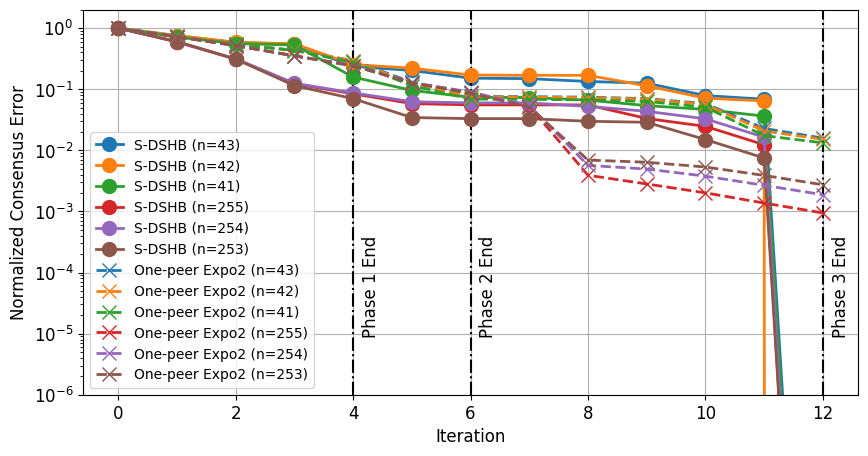

In [72]:
def generate_test_case():
    n_sub = [32, 8, 3]
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [32, 8, 2]
    n_sub_facts = [[2,2,2,2,2], [2,2,2], [2]]
    yield n_sub, n_sub_facts
    
    n_sub = [32, 6, 3]
    n_sub_facts = [[2,2,2,2,2], [3, 2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [243, 9, 3]
    n_sub_facts = [[3, 3, 3, 3, 3], [3, 3], [3]]
    yield n_sub, n_sub_facts

    n_sub = [243, 8, 3]
    n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [3]]
    yield n_sub, n_sub_facts
    
    n_sub = [243, 8, 2]
    n_sub_facts = [[3, 3, 3, 3, 3], [2, 2, 2], [2]]
    yield n_sub, n_sub_facts

plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 
plt.rc('legend', fontsize=10)
# DSHB
plot_phase=True
for n_sub, n_sub_facts in generate_test_case():
    n = sum(n_sub)
    max_period = max(len(fact) for fact in n_sub_facts)
    for sub, sub_facts in zip(n_sub, n_sub_facts):
        assert sub == np.prod(sub_facts)
    
    consensus_error = get_mse_dshb(n_sub, n_sub_facts)
    plt.semilogy(consensus_error, label=f"S-DSHB ({n=})", marker="o", linewidth=2, markersize=10)
    if plot_phase:
        plt.axvline(max_period-1,  linestyle="-.", color="black")
        plt.text(max_period-1 + 0.15, 1e-5, 'Phase 1 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period + len(n_sub) - 2,  linestyle="-.", color="black")
        plt.text(max_period+ len(n_sub) - 2 + 0.15, 1e-5, 'Phase 2 End', fontsize=12, rotation="vertical")
        plt.axvline(max_period *2 + len(n_sub) -1,  linestyle="-.", color="black")
        plt.text(max_period *2 + len(n_sub) -1 + 0.15, 1e-5, 'Phase 3 End', fontsize=12, rotation="vertical")
        plot_phase = False

# Dyn_exp2
for i, n in enumerate([43, 42, 41, 255, 254, 253]):
    consensus_error = get_mse_exp(n, iters=12)
    plt.semilogy(consensus_error, '--', label=f"One-peer Expo2 ({n=})", marker="x", linewidth=2, markersize=10,
                 color=f"C{i}")

plt.ylim(1e-6, 2e0)
plt.xlabel("Iteration")
plt.ylabel("Normalized Consensus Error")
plt.grid(True)
plt.legend()
plt.show()